## Test bias-hardening 

In [1]:
import os
os.environ["DISABLE_MPI"]="true"
from fgbias import setup_AAAA_recon, get_bias_terms, get_cl_smooth, dummy_teb, ClBinner
from falafel import utils as futils, qe
import numpy as np
from orphics import maps
import healpy as hp
from pixell import curvedsky
import matplotlib.pyplot as plt
import healpy as hp
import pytempura

In [2]:
# Set some options for the lensing reconstruction

In [3]:
lmin = 100
lmax = 2000
mlmax = 2500

In [4]:
# Set noise level and beam (this will enter into to the Cinv filter used for lensing reconstruction)
# we're not actually going to add noise to the simulation here
noise_sigma = 5. #muK
beam_fwhm=1.5 #arcmin
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./beam**2
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

#use falafel to get theory Cls 
ucls,tcls = futils.get_theory_dicts(grad=True, nells=nells, lmax=mlmax)

Generate point-source map and convert to alm

In [5]:
nside=2048
nsource=10000
flux=50. #mJY

#assing to random pixels 
npix = hp.nside2npix(nside)
flux_density_map = np.zeros(hp.nside2npix(nside))
pixel_area = hp.nside2pixarea(nside)
source_pix = np.random.choice(np.arange(npix),size=nsource)
np.add.at(flux_density_map, source_pix, flux/pixel_area)
#flux_density_map is in mJY per sr
#convert to CMB temp units
def flux_density_to_temp(freq):
    #get factor for converting delta flux density in MJy/sr
    #to delta T in CMB units. freq in GHz
    freq = float(freq)
    x = freq / 56.8
    return (1.05e3 * (np.exp(x)-1)**2 *
            np.exp(-x) * (freq / 100)**-4)

source_temp_map = (flux_density_map / 1.e9) * flux_density_to_temp(150.)

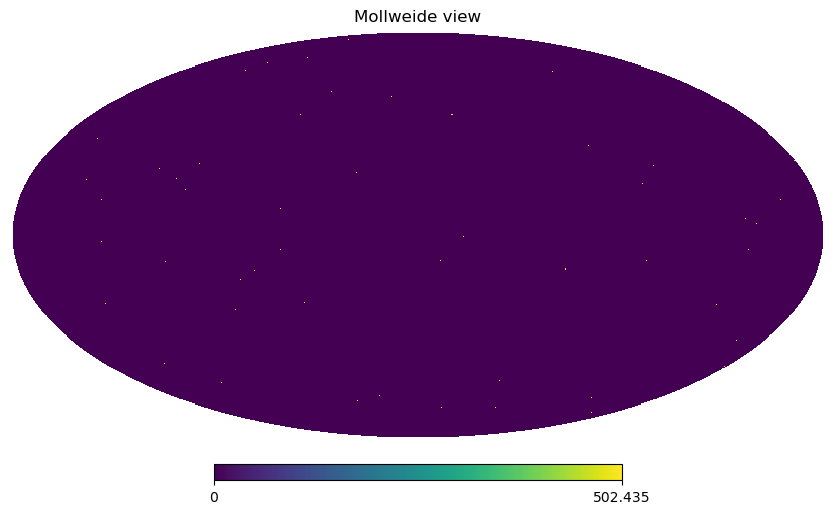

In [6]:
%matplotlib inline

hp.mollview(source_temp_map)

convert to alm and filter
#convolve with beam first?

In [7]:
source_temp_map_beam_convolved = hp.smoothing(source_temp_map, fwhm=np.radians(beam_fwhm/60))
fg_alm_beamed = hp.map2alm(source_temp_map_beam_convolved,lmax=mlmax)
fg_alm = curvedsky.almxfl(fg_alm_beamed, 1./hp.gauss_beam(np.radians(beam_fwhm/60), lmax=mlmax))

In [8]:
#fg_alm = hp.map2alm(source_temp_map, lmax=mlmax)

In [9]:
fg_alm_filtered = qe.filter_alms(fg_alm, 1./tcls["TT"] ,lmin=lmin,lmax=lmax)

estimate phi

In [10]:
px = qe.pixelization(nside=2048)
phi_nonorm = qe.qe_all(px, ucls, mlmax,
                        fTalm=fg_alm_filtered, fEalm=None,fBalm=None,
                        estimators=['TT'],
                        xfTalm=fg_alm_filtered, xfEalm=None,xfBalm=None)['TT']

run source estimator

In [11]:
src_nonorm = qe.qe_source(px, mlmax, fg_alm_filtered,
                          xfTalm=fg_alm_filtered)

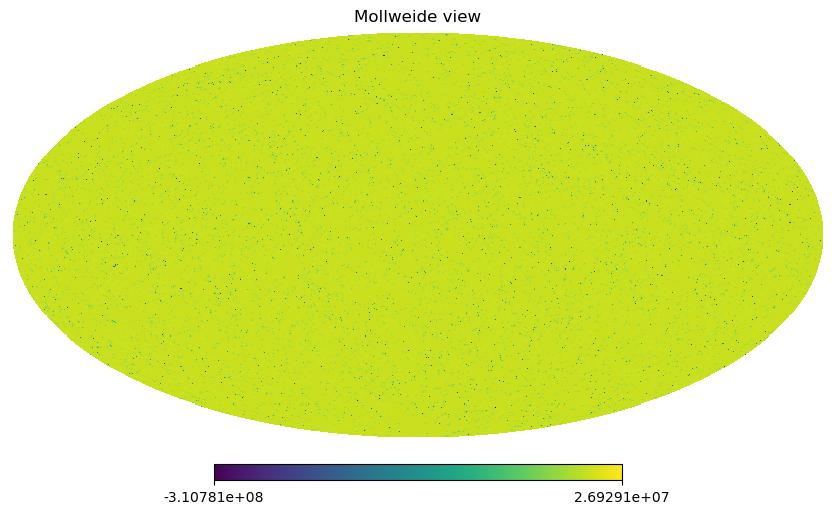

In [13]:
%matplotlib inline

hp.mollview(hp.alm2map(src_nonorm, nside=1024))

Why are the sources in the source reconstruction negative? Shouldn't this just be filtered T^2?

get norms and responses

In [74]:
R_tt_src = pytempura.get_cross(
    'TT','SRC',ucls,tcls,lmin,lmax,
    k_ellmax=mlmax)
R_src_tt = pytempura.get_cross(
    'SRC','TT',ucls,tcls,lmin,lmax,
    k_ellmax=mlmax)
assert np.all(R_tt_src == R_src_tt)
norm_src = pytempura.get_norms(
        ['src'], ucls, ucls, tcls,
        lmin, lmax,
        k_ellmax=mlmax)['src']
norm_lens = pytempura.get_norms(
        ['TT'], ucls, ucls, tcls,
        lmin, lmax,
        k_ellmax=mlmax)['TT']

 Response (TT)
use new TT
 Response (TT)


Bias hardening works because we can relate the contamination of the lensing reconstruction
to the source reconstruction times some response function R_src_tt. i.e. 

$
\begin{pmatrix}
\hat{\phi}_L\\
\hat{s}_L
\end{pmatrix}
=
\begin{pmatrix}
1 & N^{\phi}R_L\\
N^{s}R_L & 1
\end{pmatrix} $

So in our case, where the true $\phi=0$, the $\hat{\phi}$ reconstruction should be equal to $N^{\phi}_L R_L s_L = N^{\phi}_L R_L \hat{s}_L$.

We can test this directly:

In [70]:
#normalise phi and take gradient only
phi = curvedsky.almxfl(phi_nonorm[0], norm_lens[0])

#get the expected contamination of the phi reconstruction from the source reconstruction
phi_from_src = curvedsky.almxfl(src_nonorm, norm_src * norm_lens[0] * R_src_tt)

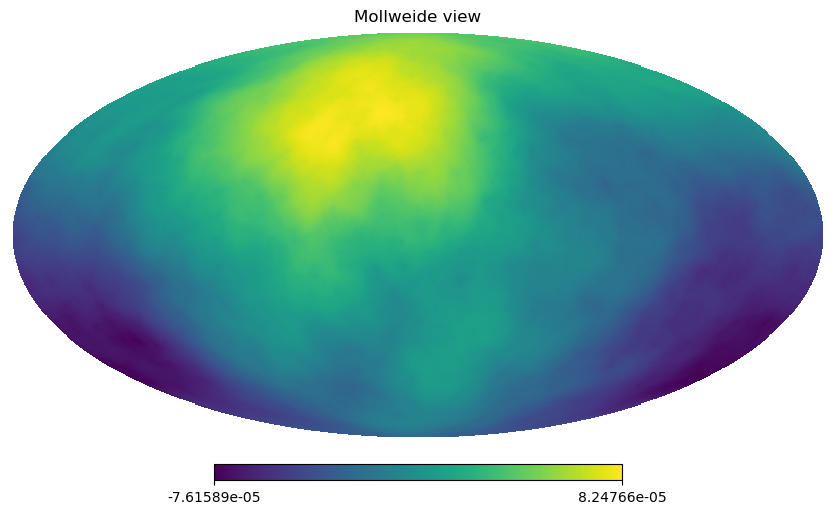

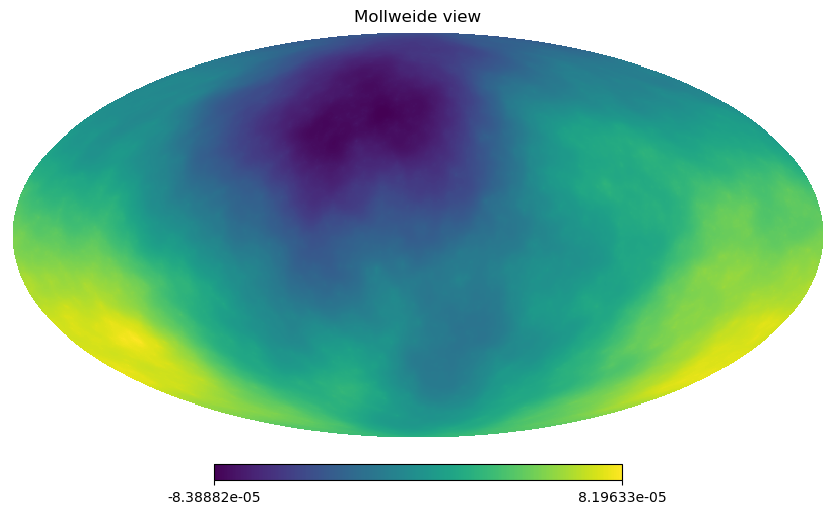

In [71]:
%matplotlib inline

hp.mollview(hp.alm2map(phi, nside=1024))
hp.mollview(hp.alm2map(phi_from_src, nside=1024))
#hp.mollview(hp.alm2map(phi_bh_nonorm, nside=1024))

## For some reason $N^{\kappa}_L R_L \hat{s}_L$ has the opposite sign to $\hat{\phi}$!! Why!!!?

Let's use the so-lenspipe bias-hardening qfunc

In [89]:
import solenspipe

qfunc_psh = solenspipe.get_qfunc(
                px, ucls, mlmax, "TT", est2='SRC', Al1=norm_lens,
                Al2=norm_src, R12=R_src_tt)
#This expects (T,E,B) but can just use zeros for E and B
phi_psh = qfunc_psh( (fg_alm_filtered, np.zeros_like(fg_alm_filtered), np.zeros_like(fg_alm_filtered)),
                    (fg_alm_filtered, np.zeros_like(fg_alm_filtered), np.zeros_like(fg_alm_filtered)) )[0] #take the gradient leg

['TT', 'TE', 'EE', 'EB', 'TB', 'MV', 'MVPOL', 'SRC']
TT


Look at the map...again it looks as if this is not working....

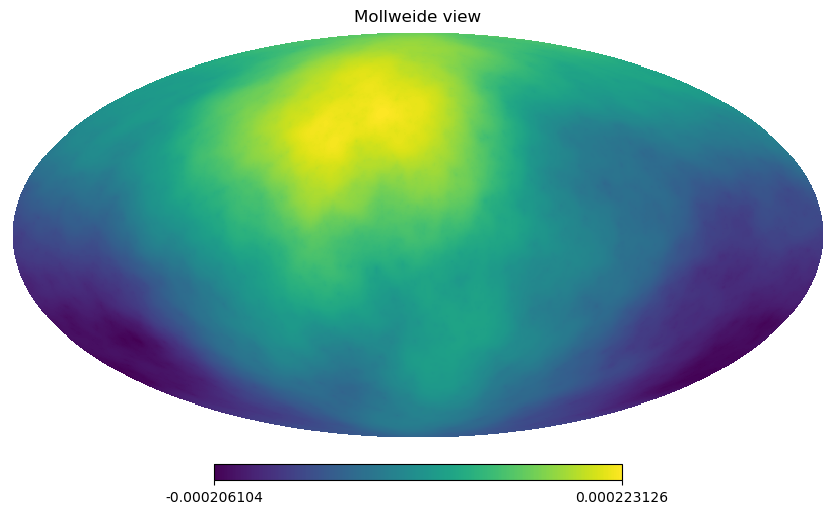

In [86]:
%matplotlib inline

hp.mollview(hp.alm2map(phi_psh, nside=1024))

confirm with $C_L^{\phi\phi}$...

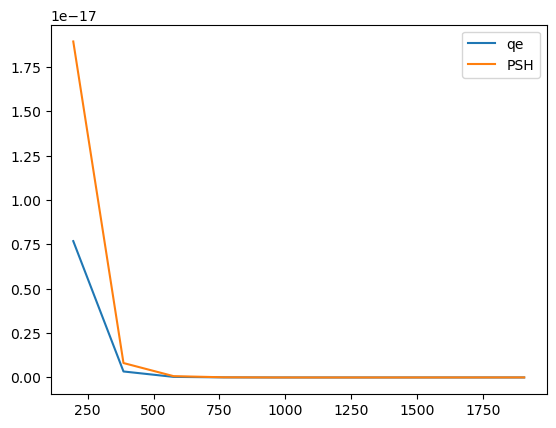

In [91]:
%matplotlib inline

fig,ax=plt.subplots()

#function for binning Cl
binner = ClBinner(lmin=lmin, lmax=lmax, nbin=10)

ax.plot(binner.bin_mids, binner(
    curvedsky.alm2cl(phi, phi)), label="qe")
ax.plot(binner.bin_mids, binner(
    curvedsky.alm2cl(phi, phi_psh)), label="PSH")
ax.legend()

Indeed the bias-hardened estimator is worse - roughly a factor of two, consistent with the correction having the wrong sign...